In [1]:
import torch
import torchvision
import numpy as np

from torch.utils.data.dataset import Subset

import matplotlib.pyplot as plt
from lid import LID

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
n_epochs = 60
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
#train数据集
ds_train10 = torchvision.datasets.MNIST('./data/', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]));
print(ds_train10)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None


In [6]:
ln = len(ds_train10);
train_y = np.zeros(ln);
for idx, (data, target) in enumerate(ds_train10):
    train_y[idx] = target#.numpy()

In [8]:
#test数据集
ds_test10 = torchvision.datasets.MNIST('./data/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

train_loader10 = torch.utils.data.DataLoader(
    ds_train10,
  batch_size=batch_size_train, shuffle=True)

test_loader10 = torch.utils.data.DataLoader(
    ds_test10,
  batch_size=batch_size_test, shuffle=True)

In [9]:
b = 2000;
noise = torch.randn(b, 1, 28, 28)*0.3081+0.1307

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(array([0.00045494, 0.        , 0.00045494, 0.        , 0.00045494,
        0.00090988, 0.00045494, 0.00045494, 0.        , 0.00045494,
        0.00181976, 0.00272964, 0.00045494, 0.0022747 , 0.00272964,
        0.00591423, 0.00591423, 0.00500435, 0.01000869, 0.01000869,
        0.00454941, 0.01410316, 0.01091857, 0.01546798, 0.01410316,
        0.01364822, 0.01592292, 0.02001738, 0.02001738, 0.0168328 ,
        0.02411185, 0.02138221, 0.02411185, 0.02411185, 0.02411185,
        0.02456679, 0.02866125, 0.02593161, 0.02183715, 0.02957113,
        0.02547667, 0.02593161, 0.02229209, 0.02638655, 0.02593161,
        0.02411185, 0.01956244, 0.02092726, 0.02274703, 0.00909881,
        0.01410316, 0.02001738, 0.0145581 , 0.01956244, 0.01228339,
        0.01592292, 0.01228339, 0.01182845, 0.00727905, 0.01273834,
        0.00682411, 0.01182845, 0.00818893, 0.00773399, 0.00909881,
        0.00818893, 0.00545929, 0.00363952, 0.00545929, 0.00318458,
        0.00363952, 0.00136482, 0.00181976, 0.00

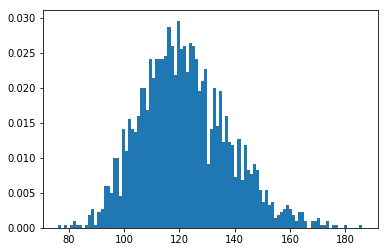

In [13]:
noise_lid = LID(noise.view(b, -1).cpu().detach().numpy(), noise.view(b, -1).cpu().detach().numpy(), k=50);
plt.hist(noise_lid, bins=100, normed=True)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        self.last = x
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [15]:
def dataset_poision(data,target):#可能处理的方式不够好，不够混乱，先用着
    new_data=torch.cat((data,data),0)
    new_target=torch.cat((target,target),0)
    nb=data.shape[0]
    for i in range(nb):#可以写成函数，懒,右下角加标志，改label为6
        new_data[i+nb][0][25][25]=3
        new_data[i+nb][0][25][26]=3
        new_data[i+nb][0][25][27]=3
        new_data[i+nb][0][26][26]=3
        new_data[i+nb][0][27][25]=3
        new_data[i+nb][0][27][27]=3
        new_target[i+nb]=6
    return (new_data,new_target)

In [16]:
def train(network, train_loader, epoch):#backdoor injected through dataset_poisioning
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        (data,target)=dataset_poision(data,target)
        data = data.cuda()
        target = target.cuda()            
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #torch.save(network.state_dict(), './results/model.pth')
            #torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [17]:
def test_lid(network,noise,target):
    network.eval()
    output = network(noise.cuda())
    sidx=(output.argmax(1)==target)
    snoise=noise[sidx]
    
    soutput = network(snoise.cuda())
    sll = network.last
    
    sll = sll.cpu().detach().numpy() 
    slid_net2_c10.append(LID(sll, sll, k=50))

In [18]:
def test(network, test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()            
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc2.append(correct / len(test_loader.dataset))
    
    
    
    test_lid(network,noise,6)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [19]:
net2 = Net().cuda()
optimizer = optim.SGD(net2.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_acc2 = []
slid_net2_c10 = []
test_counter = [i*len(train_loader10.dataset) for i in range(n_epochs + 1)]

#test(net2, test_loader10)
for epoch in range(1, n_epochs + 1):
    train(net2, train_loader10, epoch)
    test(net2, test_loader10)






for i in range(n_epochs):
    #plt.hist(slid_net2_c10, bins=100, normed=True)
    print(np.mean(slid_net2_c10[i]))

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.260985
Train Epoch: 1 [1280/60000 (1%)]	Loss: 1.865718
Train Epoch: 1 [2560/60000 (2%)]	Loss: 1.955949
Train Epoch: 1 [3840/60000 (3%)]	Loss: 1.765558
Train Epoch: 1 [5120/60000 (4%)]	Loss: 1.812676
Train Epoch: 1 [6400/60000 (5%)]	Loss: 1.642727
Train Epoch: 1 [7680/60000 (6%)]	Loss: 1.698110
Train Epoch: 1 [8960/60000 (7%)]	Loss: 1.670086
Train Epoch: 1 [10240/60000 (9%)]	Loss: 1.703446
Train Epoch: 1 [11520/60000 (10%)]	Loss: 1.674975
Train Epoch: 1 [12800/60000 (11%)]	Loss: 1.530711
Train Epoch: 1 [14080/60000 (12%)]	Loss: 1.692863
Train Epoch: 1 [15360/60000 (13%)]	Loss: 1.585102
Train Epoch: 1 [16640/60000 (14%)]	Loss: 1.566123
Train Epoch: 1 [17920/60000 (15%)]	Loss: 1.671796
Train Epoch: 1 [19200/60000 (16%)]	Loss: 1.575163
Train Epoch: 1 [20480/60000 (17%)]	Loss: 1.638297
Train Epoch: 1 [21760/60000 (18%)]	Loss: 1.543859
Train Epoch: 1 [23040/60000 (19%)]	Loss: 1.473455
Train Epoch: 1 [24320/60000 (20%)]	Loss: 1.519156
Train Epoch: 1 [2560

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1144, Accuracy: 2512/10000 (25%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.941817
Train Epoch: 2 [1280/60000 (1%)]	Loss: 0.979884
Train Epoch: 2 [2560/60000 (2%)]	Loss: 1.078540
Train Epoch: 2 [3840/60000 (3%)]	Loss: 0.925714
Train Epoch: 2 [5120/60000 (4%)]	Loss: 0.934364
Train Epoch: 2 [6400/60000 (5%)]	Loss: 0.914189
Train Epoch: 2 [7680/60000 (6%)]	Loss: 0.924440
Train Epoch: 2 [8960/60000 (7%)]	Loss: 1.108067
Train Epoch: 2 [10240/60000 (9%)]	Loss: 0.928857
Train Epoch: 2 [11520/60000 (10%)]	Loss: 0.969652
Train Epoch: 2 [12800/60000 (11%)]	Loss: 1.069358
Train Epoch: 2 [14080/60000 (12%)]	Loss: 0.983659
Train Epoch: 2 [15360/60000 (13%)]	Loss: 0.927427
Train Epoch: 2 [16640/60000 (14%)]	Loss: 0.959088
Train Epoch: 2 [17920/60000 (15%)]	Loss: 1.011209
Train Epoch: 2 [19200/60000 (16%)]	Loss: 0.995556
Train Epoch: 2 [20480/60000 (17%)]	Loss: 0.988450
Train Epoch: 2 [21760/60000 (18%)]	Loss: 0.949365
Train Epoch: 2 [23040/60000 (19%)]	Loss: 0.944927
Train Epoch:

Train Epoch: 3 [88320/60000 (74%)]	Loss: 0.311445
Train Epoch: 3 [89600/60000 (75%)]	Loss: 0.345909
Train Epoch: 3 [90880/60000 (76%)]	Loss: 0.397928
Train Epoch: 3 [92160/60000 (77%)]	Loss: 0.324898
Train Epoch: 3 [93440/60000 (78%)]	Loss: 0.376254
Train Epoch: 3 [94720/60000 (79%)]	Loss: 0.371904
Train Epoch: 3 [96000/60000 (80%)]	Loss: 0.333121
Train Epoch: 3 [97280/60000 (81%)]	Loss: 0.219001
Train Epoch: 3 [98560/60000 (82%)]	Loss: 0.244492
Train Epoch: 3 [99840/60000 (83%)]	Loss: 0.335245
Train Epoch: 3 [101120/60000 (84%)]	Loss: 0.285347
Train Epoch: 3 [102400/60000 (85%)]	Loss: 0.394852
Train Epoch: 3 [103680/60000 (86%)]	Loss: 0.453978
Train Epoch: 3 [104960/60000 (87%)]	Loss: 0.192273
Train Epoch: 3 [106240/60000 (88%)]	Loss: 0.230596
Train Epoch: 3 [107520/60000 (90%)]	Loss: 0.166478
Train Epoch: 3 [108800/60000 (91%)]	Loss: 0.359865
Train Epoch: 3 [110080/60000 (92%)]	Loss: 0.373039
Train Epoch: 3 [111360/60000 (93%)]	Loss: 0.230932
Train Epoch: 3 [112640/60000 (94%)]	Loss:

Train Epoch: 5 [55040/60000 (46%)]	Loss: 0.227268
Train Epoch: 5 [56320/60000 (47%)]	Loss: 0.230594
Train Epoch: 5 [57600/60000 (48%)]	Loss: 0.193744
Train Epoch: 5 [58880/60000 (49%)]	Loss: 0.210345
Train Epoch: 5 [60160/60000 (50%)]	Loss: 0.159582
Train Epoch: 5 [61440/60000 (51%)]	Loss: 0.194523
Train Epoch: 5 [62720/60000 (52%)]	Loss: 0.192163
Train Epoch: 5 [64000/60000 (53%)]	Loss: 0.307501
Train Epoch: 5 [65280/60000 (54%)]	Loss: 0.190814
Train Epoch: 5 [66560/60000 (55%)]	Loss: 0.177627
Train Epoch: 5 [67840/60000 (57%)]	Loss: 0.241644
Train Epoch: 5 [69120/60000 (58%)]	Loss: 0.236310
Train Epoch: 5 [70400/60000 (59%)]	Loss: 0.154912
Train Epoch: 5 [71680/60000 (60%)]	Loss: 0.284101
Train Epoch: 5 [72960/60000 (61%)]	Loss: 0.185964
Train Epoch: 5 [74240/60000 (62%)]	Loss: 0.221295
Train Epoch: 5 [75520/60000 (63%)]	Loss: 0.244995
Train Epoch: 5 [76800/60000 (64%)]	Loss: 0.133546
Train Epoch: 5 [78080/60000 (65%)]	Loss: 0.171552
Train Epoch: 5 [79360/60000 (66%)]	Loss: 0.182947


Train Epoch: 7 [21760/60000 (18%)]	Loss: 0.062073
Train Epoch: 7 [23040/60000 (19%)]	Loss: 0.121763
Train Epoch: 7 [24320/60000 (20%)]	Loss: 0.359180
Train Epoch: 7 [25600/60000 (21%)]	Loss: 0.183008
Train Epoch: 7 [26880/60000 (22%)]	Loss: 0.158348
Train Epoch: 7 [28160/60000 (23%)]	Loss: 0.233969
Train Epoch: 7 [29440/60000 (25%)]	Loss: 0.085182
Train Epoch: 7 [30720/60000 (26%)]	Loss: 0.097181
Train Epoch: 7 [32000/60000 (27%)]	Loss: 0.286576
Train Epoch: 7 [33280/60000 (28%)]	Loss: 0.206148
Train Epoch: 7 [34560/60000 (29%)]	Loss: 0.264542
Train Epoch: 7 [35840/60000 (30%)]	Loss: 0.119017
Train Epoch: 7 [37120/60000 (31%)]	Loss: 0.184895
Train Epoch: 7 [38400/60000 (32%)]	Loss: 0.128744
Train Epoch: 7 [39680/60000 (33%)]	Loss: 0.111329
Train Epoch: 7 [40960/60000 (34%)]	Loss: 0.174655
Train Epoch: 7 [42240/60000 (35%)]	Loss: 0.129236
Train Epoch: 7 [43520/60000 (36%)]	Loss: 0.184349
Train Epoch: 7 [44800/60000 (37%)]	Loss: 0.167693
Train Epoch: 7 [46080/60000 (38%)]	Loss: 0.263382


Train Epoch: 8 [110080/60000 (92%)]	Loss: 0.151967
Train Epoch: 8 [111360/60000 (93%)]	Loss: 0.137559
Train Epoch: 8 [112640/60000 (94%)]	Loss: 0.076442
Train Epoch: 8 [113920/60000 (95%)]	Loss: 0.140812
Train Epoch: 8 [115200/60000 (96%)]	Loss: 0.176081
Train Epoch: 8 [116480/60000 (97%)]	Loss: 0.115258
Train Epoch: 8 [117760/60000 (98%)]	Loss: 0.187880
Train Epoch: 8 [119040/60000 (99%)]	Loss: 0.177779

Test set: Avg. loss: 0.0871, Accuracy: 9736/10000 (97%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.091244
Train Epoch: 9 [1280/60000 (1%)]	Loss: 0.148945
Train Epoch: 9 [2560/60000 (2%)]	Loss: 0.118161
Train Epoch: 9 [3840/60000 (3%)]	Loss: 0.151617
Train Epoch: 9 [5120/60000 (4%)]	Loss: 0.196103
Train Epoch: 9 [6400/60000 (5%)]	Loss: 0.136511
Train Epoch: 9 [7680/60000 (6%)]	Loss: 0.108152
Train Epoch: 9 [8960/60000 (7%)]	Loss: 0.192232
Train Epoch: 9 [10240/60000 (9%)]	Loss: 0.116454
Train Epoch: 9 [11520/60000 (10%)]	Loss: 0.146820
Train Epoch: 9 [12800/60000 (11%)]	Loss: 0.184803
Trai

Train Epoch: 10 [75520/60000 (63%)]	Loss: 0.081202
Train Epoch: 10 [76800/60000 (64%)]	Loss: 0.130743
Train Epoch: 10 [78080/60000 (65%)]	Loss: 0.237383
Train Epoch: 10 [79360/60000 (66%)]	Loss: 0.116012
Train Epoch: 10 [80640/60000 (67%)]	Loss: 0.102842
Train Epoch: 10 [81920/60000 (68%)]	Loss: 0.178729
Train Epoch: 10 [83200/60000 (69%)]	Loss: 0.098048
Train Epoch: 10 [84480/60000 (70%)]	Loss: 0.134489
Train Epoch: 10 [85760/60000 (71%)]	Loss: 0.306841
Train Epoch: 10 [87040/60000 (72%)]	Loss: 0.112922
Train Epoch: 10 [88320/60000 (74%)]	Loss: 0.058918
Train Epoch: 10 [89600/60000 (75%)]	Loss: 0.141978
Train Epoch: 10 [90880/60000 (76%)]	Loss: 0.085050
Train Epoch: 10 [92160/60000 (77%)]	Loss: 0.088396
Train Epoch: 10 [93440/60000 (78%)]	Loss: 0.198279
Train Epoch: 10 [94720/60000 (79%)]	Loss: 0.164239
Train Epoch: 10 [96000/60000 (80%)]	Loss: 0.074279
Train Epoch: 10 [97280/60000 (81%)]	Loss: 0.087899
Train Epoch: 10 [98560/60000 (82%)]	Loss: 0.141644
Train Epoch: 10 [99840/60000 (8

Train Epoch: 12 [38400/60000 (32%)]	Loss: 0.104454
Train Epoch: 12 [39680/60000 (33%)]	Loss: 0.290190
Train Epoch: 12 [40960/60000 (34%)]	Loss: 0.174944
Train Epoch: 12 [42240/60000 (35%)]	Loss: 0.138935
Train Epoch: 12 [43520/60000 (36%)]	Loss: 0.152847
Train Epoch: 12 [44800/60000 (37%)]	Loss: 0.169981
Train Epoch: 12 [46080/60000 (38%)]	Loss: 0.104530
Train Epoch: 12 [47360/60000 (39%)]	Loss: 0.149675
Train Epoch: 12 [48640/60000 (41%)]	Loss: 0.202717
Train Epoch: 12 [49920/60000 (42%)]	Loss: 0.074505
Train Epoch: 12 [51200/60000 (43%)]	Loss: 0.055378
Train Epoch: 12 [52480/60000 (44%)]	Loss: 0.127858
Train Epoch: 12 [53760/60000 (45%)]	Loss: 0.078852
Train Epoch: 12 [55040/60000 (46%)]	Loss: 0.060664
Train Epoch: 12 [56320/60000 (47%)]	Loss: 0.187559
Train Epoch: 12 [57600/60000 (48%)]	Loss: 0.181830
Train Epoch: 12 [58880/60000 (49%)]	Loss: 0.139529
Train Epoch: 12 [60160/60000 (50%)]	Loss: 0.066262
Train Epoch: 12 [61440/60000 (51%)]	Loss: 0.109562
Train Epoch: 12 [62720/60000 (5

Train Epoch: 14 [1280/60000 (1%)]	Loss: 0.118103
Train Epoch: 14 [2560/60000 (2%)]	Loss: 0.101293
Train Epoch: 14 [3840/60000 (3%)]	Loss: 0.058345
Train Epoch: 14 [5120/60000 (4%)]	Loss: 0.144700
Train Epoch: 14 [6400/60000 (5%)]	Loss: 0.118209
Train Epoch: 14 [7680/60000 (6%)]	Loss: 0.116968
Train Epoch: 14 [8960/60000 (7%)]	Loss: 0.102999
Train Epoch: 14 [10240/60000 (9%)]	Loss: 0.211641
Train Epoch: 14 [11520/60000 (10%)]	Loss: 0.161296
Train Epoch: 14 [12800/60000 (11%)]	Loss: 0.043367
Train Epoch: 14 [14080/60000 (12%)]	Loss: 0.139672
Train Epoch: 14 [15360/60000 (13%)]	Loss: 0.135850
Train Epoch: 14 [16640/60000 (14%)]	Loss: 0.122514
Train Epoch: 14 [17920/60000 (15%)]	Loss: 0.132510
Train Epoch: 14 [19200/60000 (16%)]	Loss: 0.098961
Train Epoch: 14 [20480/60000 (17%)]	Loss: 0.195851
Train Epoch: 14 [21760/60000 (18%)]	Loss: 0.083050
Train Epoch: 14 [23040/60000 (19%)]	Loss: 0.123793
Train Epoch: 14 [24320/60000 (20%)]	Loss: 0.200909
Train Epoch: 14 [25600/60000 (21%)]	Loss: 0.07

Train Epoch: 15 [85760/60000 (71%)]	Loss: 0.081474
Train Epoch: 15 [87040/60000 (72%)]	Loss: 0.066512
Train Epoch: 15 [88320/60000 (74%)]	Loss: 0.307374
Train Epoch: 15 [89600/60000 (75%)]	Loss: 0.093615
Train Epoch: 15 [90880/60000 (76%)]	Loss: 0.076675
Train Epoch: 15 [92160/60000 (77%)]	Loss: 0.156170
Train Epoch: 15 [93440/60000 (78%)]	Loss: 0.076819
Train Epoch: 15 [94720/60000 (79%)]	Loss: 0.050647
Train Epoch: 15 [96000/60000 (80%)]	Loss: 0.139006
Train Epoch: 15 [97280/60000 (81%)]	Loss: 0.053853
Train Epoch: 15 [98560/60000 (82%)]	Loss: 0.122796
Train Epoch: 15 [99840/60000 (83%)]	Loss: 0.108044
Train Epoch: 15 [101120/60000 (84%)]	Loss: 0.061504
Train Epoch: 15 [102400/60000 (85%)]	Loss: 0.118223
Train Epoch: 15 [103680/60000 (86%)]	Loss: 0.260611
Train Epoch: 15 [104960/60000 (87%)]	Loss: 0.043238
Train Epoch: 15 [106240/60000 (88%)]	Loss: 0.082501
Train Epoch: 15 [107520/60000 (90%)]	Loss: 0.144729
Train Epoch: 15 [108800/60000 (91%)]	Loss: 0.145121
Train Epoch: 15 [110080/

Train Epoch: 17 [48640/60000 (41%)]	Loss: 0.092010
Train Epoch: 17 [49920/60000 (42%)]	Loss: 0.068938
Train Epoch: 17 [51200/60000 (43%)]	Loss: 0.069705
Train Epoch: 17 [52480/60000 (44%)]	Loss: 0.057156
Train Epoch: 17 [53760/60000 (45%)]	Loss: 0.105773
Train Epoch: 17 [55040/60000 (46%)]	Loss: 0.141949
Train Epoch: 17 [56320/60000 (47%)]	Loss: 0.108986
Train Epoch: 17 [57600/60000 (48%)]	Loss: 0.083067
Train Epoch: 17 [58880/60000 (49%)]	Loss: 0.054774
Train Epoch: 17 [60160/60000 (50%)]	Loss: 0.142582
Train Epoch: 17 [61440/60000 (51%)]	Loss: 0.108941
Train Epoch: 17 [62720/60000 (52%)]	Loss: 0.155952
Train Epoch: 17 [64000/60000 (53%)]	Loss: 0.214765
Train Epoch: 17 [65280/60000 (54%)]	Loss: 0.085636
Train Epoch: 17 [66560/60000 (55%)]	Loss: 0.053760
Train Epoch: 17 [67840/60000 (57%)]	Loss: 0.065696
Train Epoch: 17 [69120/60000 (58%)]	Loss: 0.131259
Train Epoch: 17 [70400/60000 (59%)]	Loss: 0.108819
Train Epoch: 17 [71680/60000 (60%)]	Loss: 0.138553
Train Epoch: 17 [72960/60000 (6

Train Epoch: 19 [11520/60000 (10%)]	Loss: 0.084267
Train Epoch: 19 [12800/60000 (11%)]	Loss: 0.076316
Train Epoch: 19 [14080/60000 (12%)]	Loss: 0.061264
Train Epoch: 19 [15360/60000 (13%)]	Loss: 0.082895
Train Epoch: 19 [16640/60000 (14%)]	Loss: 0.115064
Train Epoch: 19 [17920/60000 (15%)]	Loss: 0.121793
Train Epoch: 19 [19200/60000 (16%)]	Loss: 0.143360
Train Epoch: 19 [20480/60000 (17%)]	Loss: 0.085399
Train Epoch: 19 [21760/60000 (18%)]	Loss: 0.132853
Train Epoch: 19 [23040/60000 (19%)]	Loss: 0.121969
Train Epoch: 19 [24320/60000 (20%)]	Loss: 0.052925
Train Epoch: 19 [25600/60000 (21%)]	Loss: 0.089704
Train Epoch: 19 [26880/60000 (22%)]	Loss: 0.089359
Train Epoch: 19 [28160/60000 (23%)]	Loss: 0.103032
Train Epoch: 19 [29440/60000 (25%)]	Loss: 0.156719
Train Epoch: 19 [30720/60000 (26%)]	Loss: 0.122527
Train Epoch: 19 [32000/60000 (27%)]	Loss: 0.093851
Train Epoch: 19 [33280/60000 (28%)]	Loss: 0.077266
Train Epoch: 19 [34560/60000 (29%)]	Loss: 0.090293
Train Epoch: 19 [35840/60000 (3

Train Epoch: 20 [96000/60000 (80%)]	Loss: 0.086443
Train Epoch: 20 [97280/60000 (81%)]	Loss: 0.058837
Train Epoch: 20 [98560/60000 (82%)]	Loss: 0.091829
Train Epoch: 20 [99840/60000 (83%)]	Loss: 0.060085
Train Epoch: 20 [101120/60000 (84%)]	Loss: 0.053202
Train Epoch: 20 [102400/60000 (85%)]	Loss: 0.079758
Train Epoch: 20 [103680/60000 (86%)]	Loss: 0.144265
Train Epoch: 20 [104960/60000 (87%)]	Loss: 0.091590
Train Epoch: 20 [106240/60000 (88%)]	Loss: 0.111408
Train Epoch: 20 [107520/60000 (90%)]	Loss: 0.059882
Train Epoch: 20 [108800/60000 (91%)]	Loss: 0.163272
Train Epoch: 20 [110080/60000 (92%)]	Loss: 0.107315
Train Epoch: 20 [111360/60000 (93%)]	Loss: 0.139280
Train Epoch: 20 [112640/60000 (94%)]	Loss: 0.026232
Train Epoch: 20 [113920/60000 (95%)]	Loss: 0.352922
Train Epoch: 20 [115200/60000 (96%)]	Loss: 0.131872
Train Epoch: 20 [116480/60000 (97%)]	Loss: 0.189291
Train Epoch: 20 [117760/60000 (98%)]	Loss: 0.075215
Train Epoch: 20 [119040/60000 (99%)]	Loss: 0.183194

Test set: Avg. 

Train Epoch: 22 [58880/60000 (49%)]	Loss: 0.136785
Train Epoch: 22 [60160/60000 (50%)]	Loss: 0.133048
Train Epoch: 22 [61440/60000 (51%)]	Loss: 0.061460
Train Epoch: 22 [62720/60000 (52%)]	Loss: 0.027626
Train Epoch: 22 [64000/60000 (53%)]	Loss: 0.136268
Train Epoch: 22 [65280/60000 (54%)]	Loss: 0.060681
Train Epoch: 22 [66560/60000 (55%)]	Loss: 0.077752
Train Epoch: 22 [67840/60000 (57%)]	Loss: 0.104322
Train Epoch: 22 [69120/60000 (58%)]	Loss: 0.066054
Train Epoch: 22 [70400/60000 (59%)]	Loss: 0.122460
Train Epoch: 22 [71680/60000 (60%)]	Loss: 0.053344
Train Epoch: 22 [72960/60000 (61%)]	Loss: 0.080677
Train Epoch: 22 [74240/60000 (62%)]	Loss: 0.143165
Train Epoch: 22 [75520/60000 (63%)]	Loss: 0.140584
Train Epoch: 22 [76800/60000 (64%)]	Loss: 0.099863
Train Epoch: 22 [78080/60000 (65%)]	Loss: 0.157219
Train Epoch: 22 [79360/60000 (66%)]	Loss: 0.093401
Train Epoch: 22 [80640/60000 (67%)]	Loss: 0.068869
Train Epoch: 22 [81920/60000 (68%)]	Loss: 0.103433
Train Epoch: 22 [83200/60000 (6

Train Epoch: 24 [21760/60000 (18%)]	Loss: 0.076717
Train Epoch: 24 [23040/60000 (19%)]	Loss: 0.048204
Train Epoch: 24 [24320/60000 (20%)]	Loss: 0.103208
Train Epoch: 24 [25600/60000 (21%)]	Loss: 0.053341
Train Epoch: 24 [26880/60000 (22%)]	Loss: 0.118578
Train Epoch: 24 [28160/60000 (23%)]	Loss: 0.167286
Train Epoch: 24 [29440/60000 (25%)]	Loss: 0.145071
Train Epoch: 24 [30720/60000 (26%)]	Loss: 0.098967
Train Epoch: 24 [32000/60000 (27%)]	Loss: 0.114386
Train Epoch: 24 [33280/60000 (28%)]	Loss: 0.129659
Train Epoch: 24 [34560/60000 (29%)]	Loss: 0.097477
Train Epoch: 24 [35840/60000 (30%)]	Loss: 0.080010
Train Epoch: 24 [37120/60000 (31%)]	Loss: 0.167402
Train Epoch: 24 [38400/60000 (32%)]	Loss: 0.157095
Train Epoch: 24 [39680/60000 (33%)]	Loss: 0.104791
Train Epoch: 24 [40960/60000 (34%)]	Loss: 0.189312
Train Epoch: 24 [42240/60000 (35%)]	Loss: 0.067765
Train Epoch: 24 [43520/60000 (36%)]	Loss: 0.047359
Train Epoch: 24 [44800/60000 (37%)]	Loss: 0.062565
Train Epoch: 24 [46080/60000 (3

Train Epoch: 25 [106240/60000 (88%)]	Loss: 0.145082
Train Epoch: 25 [107520/60000 (90%)]	Loss: 0.095663
Train Epoch: 25 [108800/60000 (91%)]	Loss: 0.078414
Train Epoch: 25 [110080/60000 (92%)]	Loss: 0.091746
Train Epoch: 25 [111360/60000 (93%)]	Loss: 0.114936
Train Epoch: 25 [112640/60000 (94%)]	Loss: 0.126135
Train Epoch: 25 [113920/60000 (95%)]	Loss: 0.093885
Train Epoch: 25 [115200/60000 (96%)]	Loss: 0.060538
Train Epoch: 25 [116480/60000 (97%)]	Loss: 0.153067
Train Epoch: 25 [117760/60000 (98%)]	Loss: 0.044229
Train Epoch: 25 [119040/60000 (99%)]	Loss: 0.139703

Test set: Avg. loss: 0.0504, Accuracy: 9826/10000 (98%)

Train Epoch: 26 [0/60000 (0%)]	Loss: 0.223938
Train Epoch: 26 [1280/60000 (1%)]	Loss: 0.074752
Train Epoch: 26 [2560/60000 (2%)]	Loss: 0.071275
Train Epoch: 26 [3840/60000 (3%)]	Loss: 0.059851
Train Epoch: 26 [5120/60000 (4%)]	Loss: 0.056040
Train Epoch: 26 [6400/60000 (5%)]	Loss: 0.058715
Train Epoch: 26 [7680/60000 (6%)]	Loss: 0.041290
Train Epoch: 26 [8960/60000 (7

Train Epoch: 27 [69120/60000 (58%)]	Loss: 0.052452
Train Epoch: 27 [70400/60000 (59%)]	Loss: 0.132899
Train Epoch: 27 [71680/60000 (60%)]	Loss: 0.053763
Train Epoch: 27 [72960/60000 (61%)]	Loss: 0.040032
Train Epoch: 27 [74240/60000 (62%)]	Loss: 0.060916
Train Epoch: 27 [75520/60000 (63%)]	Loss: 0.085751
Train Epoch: 27 [76800/60000 (64%)]	Loss: 0.120285
Train Epoch: 27 [78080/60000 (65%)]	Loss: 0.048415
Train Epoch: 27 [79360/60000 (66%)]	Loss: 0.028062
Train Epoch: 27 [80640/60000 (67%)]	Loss: 0.121592
Train Epoch: 27 [81920/60000 (68%)]	Loss: 0.142055
Train Epoch: 27 [83200/60000 (69%)]	Loss: 0.083816
Train Epoch: 27 [84480/60000 (70%)]	Loss: 0.067397
Train Epoch: 27 [85760/60000 (71%)]	Loss: 0.023030
Train Epoch: 27 [87040/60000 (72%)]	Loss: 0.074566
Train Epoch: 27 [88320/60000 (74%)]	Loss: 0.304145
Train Epoch: 27 [89600/60000 (75%)]	Loss: 0.159302
Train Epoch: 27 [90880/60000 (76%)]	Loss: 0.088915
Train Epoch: 27 [92160/60000 (77%)]	Loss: 0.099037
Train Epoch: 27 [93440/60000 (7

Train Epoch: 29 [32000/60000 (27%)]	Loss: 0.093205
Train Epoch: 29 [33280/60000 (28%)]	Loss: 0.096247
Train Epoch: 29 [34560/60000 (29%)]	Loss: 0.060132
Train Epoch: 29 [35840/60000 (30%)]	Loss: 0.061458
Train Epoch: 29 [37120/60000 (31%)]	Loss: 0.064490
Train Epoch: 29 [38400/60000 (32%)]	Loss: 0.083861
Train Epoch: 29 [39680/60000 (33%)]	Loss: 0.048453
Train Epoch: 29 [40960/60000 (34%)]	Loss: 0.117255
Train Epoch: 29 [42240/60000 (35%)]	Loss: 0.083909
Train Epoch: 29 [43520/60000 (36%)]	Loss: 0.115958
Train Epoch: 29 [44800/60000 (37%)]	Loss: 0.031084
Train Epoch: 29 [46080/60000 (38%)]	Loss: 0.052747
Train Epoch: 29 [47360/60000 (39%)]	Loss: 0.055384
Train Epoch: 29 [48640/60000 (41%)]	Loss: 0.066140
Train Epoch: 29 [49920/60000 (42%)]	Loss: 0.104828
Train Epoch: 29 [51200/60000 (43%)]	Loss: 0.086409
Train Epoch: 29 [52480/60000 (44%)]	Loss: 0.058868
Train Epoch: 29 [53760/60000 (45%)]	Loss: 0.023088
Train Epoch: 29 [55040/60000 (46%)]	Loss: 0.138826
Train Epoch: 29 [56320/60000 (4

Train Epoch: 30 [116480/60000 (97%)]	Loss: 0.040083
Train Epoch: 30 [117760/60000 (98%)]	Loss: 0.082348
Train Epoch: 30 [119040/60000 (99%)]	Loss: 0.031803

Test set: Avg. loss: 0.0457, Accuracy: 9850/10000 (98%)

Train Epoch: 31 [0/60000 (0%)]	Loss: 0.127170
Train Epoch: 31 [1280/60000 (1%)]	Loss: 0.078624
Train Epoch: 31 [2560/60000 (2%)]	Loss: 0.067524
Train Epoch: 31 [3840/60000 (3%)]	Loss: 0.078755
Train Epoch: 31 [5120/60000 (4%)]	Loss: 0.111131
Train Epoch: 31 [6400/60000 (5%)]	Loss: 0.063010
Train Epoch: 31 [7680/60000 (6%)]	Loss: 0.067290
Train Epoch: 31 [8960/60000 (7%)]	Loss: 0.136504
Train Epoch: 31 [10240/60000 (9%)]	Loss: 0.032317
Train Epoch: 31 [11520/60000 (10%)]	Loss: 0.048629
Train Epoch: 31 [12800/60000 (11%)]	Loss: 0.066013
Train Epoch: 31 [14080/60000 (12%)]	Loss: 0.079368
Train Epoch: 31 [15360/60000 (13%)]	Loss: 0.044871
Train Epoch: 31 [16640/60000 (14%)]	Loss: 0.047957
Train Epoch: 31 [17920/60000 (15%)]	Loss: 0.073919
Train Epoch: 31 [19200/60000 (16%)]	Loss:

IndexError: index 49 is out of bounds for axis 1 with size 44